In [1]:
import numpy as np
import cv2
from scipy.fft import fft
import matplotlib.pyplot as plt
import os
import time
import pandas as pd

In [2]:
video_path = r"C:\Users\cpesther\Desktop\New CBF Videos\Plate2_Culture1_Pre_0003.avi"
sampling_rate = 60
power_threshold = 5

In [3]:
# Open video
print(f'Loading video {video_path}...')
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError(f'ERROR: Cannot open video {video_path}')

# Calculate some details
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

Loading video C:\Users\cpesther\Desktop\New CBF Videos\Plate2_Culture1_Pre_0003.avi...


In [4]:
# Region of interest (ROI): full frame (can be modified for manual selection)
roi_x = np.arange(frame_width)
roi_y = np.arange(frame_height)

In [5]:
# Reset cap read, just to be safe
print('Converting to grayscale...')
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Preallocate array for grayscale frames
grayscale_frames = np.zeros((num_frames, frame_height, frame_width), dtype=np.uint8)

# Read and convert frames
for i in range(num_frames):
    ret, frame = cap.read()
    if not ret:
        break
    # Convert frame to grayscale using OpenCV
    grayscale_frames[i] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

Converting to grayscale...


In [6]:
print('Reshaping to time series...')
_ , height, width = grayscale_frames.shape  # first value is num_frames, but we already calculated that
num_pixels = height * width
grayscale_frames_float = grayscale_frames.astype(np.float32)  # convert to float

# Subtract mean for each pixel in one vectorized operation
print('Normalizing data...')
pixel_time_series = grayscale_frames_float.reshape(num_pixels, num_frames)
clean_time_series = pixel_time_series - pixel_time_series.mean(axis=1, keepdims=True)

Reshaping to time series...
Normalizing data...


In [7]:
from scipy.io import savemat
test_series = clean_time_series[:10]
mat_dict = {
    'test_series': clean_time_series[:10]
}

# Save to MATLAB .mat file
savemat('gtest_series.mat', mat_dict)

In [8]:
# Preallocate lists for results
fft_length = num_frames // 2 + 1  # keep only first half b/c second half is redundant
num_pixels = len(clean_time_series)

# Preallocate arrays for results
all_pixel_psds = np.empty((num_pixels, fft_length), dtype=np.float32)
all_max_pixel_psds = np.empty(num_pixels, dtype=np.float32)

# Run the actual iteration over each time series provided
print('Performing FFT calculations...')
start = time.time()
for index, intensity_time_series in enumerate(clean_time_series):                         #xxx implement non test

    # Only update text every 25 values
    if index % 25 == False:
        print(f'Processing {index} of {num_pixels} pixels...', end='\r')
    
    # Calculate FFT and trim the result to only the first half
    fft_result = fft(intensity_time_series)[:fft_length] 

    # Calculate PSD values
    psd = (1 / (num_frames * sampling_rate)) * np.abs(fft_result) ** 2  # calculate PSD
    psd[1:-1] *= 2  # double all values (except first and last) b/c we removed all the back half values
    psd[:15] = 0    # remove very low frequency noise (first 15 values)
    
    # Store values into list
    all_pixel_psds[index, :] = psd
    all_max_pixel_psds[index] = np.max(psd)

print(f'Finished FFT analysis in {round(time.time() - start, 2)} seconds')

Performing FFT calculations...
Finished FFT analysis in 98.72 seconds.


In [9]:
# Now that we're outside of the loop, we can do some more calculations
# First, we'll calculate the maximum power of each pixel
print('Performing final calculations...')

# And calculate the frequency vector so we can plot the PSD nicely
frequency_vector = np.linspace(0, sampling_rate / 2, num_frames // 2 + 1)

# Average all the PSDs together to get one PSD representative of the whole video
mean_psd = np.mean(all_pixel_psds, axis=0)

# Calculate the percent ciliation by counting how many are above a certain
# power threshold (fraction of functional ciliated area (maybe?)). 
FFCA = np.sum(all_max_pixel_psds > power_threshold) / all_max_pixel_psds.size

Performing final calculations...


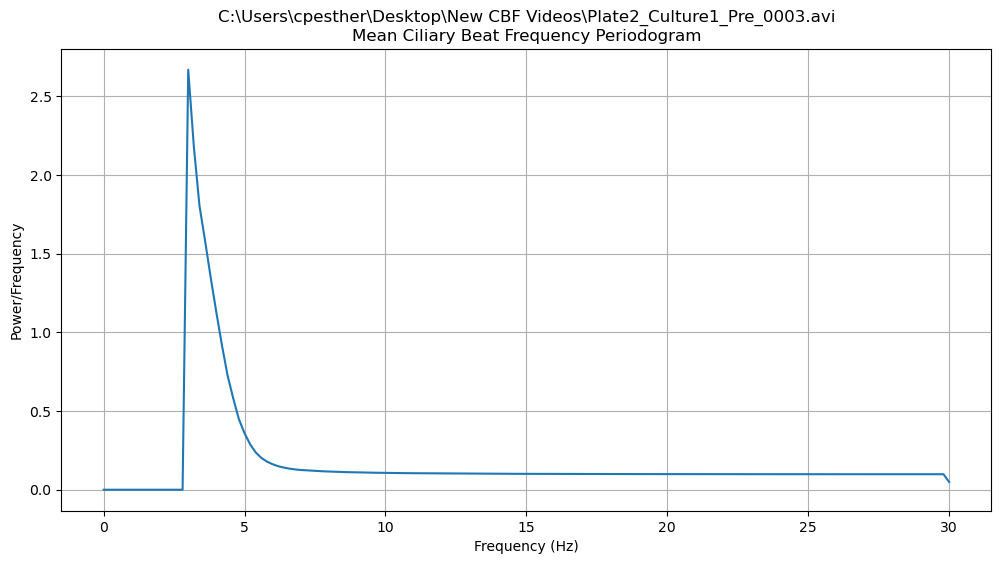

In [10]:
# Plot mean PSD periodogram
plt.figure(figsize=(12,6))
plt.plot(frequency_vector, mean_psd)
plt.grid(True)
plt.title(f'{video_path}\nMean Ciliary Beat Frequency Periodogram')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency')
plt.show()

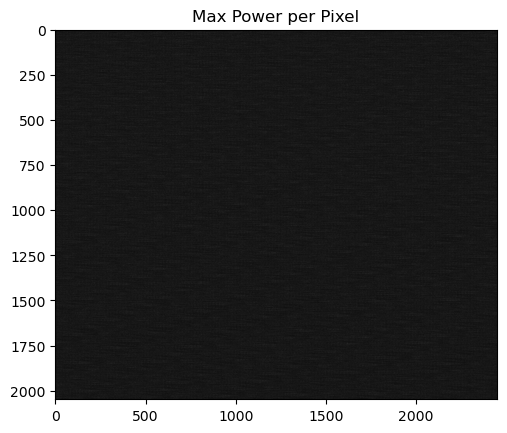

In [11]:
# Display max PSD per pixel
max_psd_image = all_max_pixel_psds.reshape(-1, frame_width)  # reshape back to image dimensions
plt.figure()
plt.imshow(max_psd_image / np.max(all_max_pixel_psds), cmap='gray')
plt.title('Max Power per Pixel')
plt.show()

In [12]:
FFCA

0.3394212909773284

In [ ]:
# First, define a function that iterates over a list of time series 
# and calculates the FFT. We can now use this function on multiple 
# processes to speed up this iterative process.
def perform_FFT(chunk_time_series, num_frames, sampling_rate, print_status=False):
    
    """
    This function performs a FFT on a list of pixel time series. 
    We have defined it as its own function so that we can break the 
    total number of pixels into multiple chunks and multiprocess this
    process. All chunks get put back together at the end.
    """

   
    
    # Preallocate lists for results
    fft_length = num_frames // 2 + 1  # keep only first half b/c second half is redundant
    num_pixels = len(chunk_time_series)

    # Preallocate arrays for results
    pixel_psds = np.empty((num_pixels, fft_length), dtype=np.float32)
    max_pixel_psds = np.empty(num_pixels, dtype=np.float32)

    # Run the actual iteration over each time series provided
    for index, intensity_time_series in enumerate(chunk_time_series):

        if print_status:
            print(f'Processing {index} of {num_pixels} pixels...', end='\r')
        
        # Calculate FFT and trim the result to only the first half
        fft_result = fft(intensity_time_series)[:fft_length] 
    
        # Calculate PSD values
        psd = (1 / (num_frames * sampling_rate)) * np.abs(fft_result) ** 2  # calculate PSD
        psd[1:-1] *= 2  # double all values (except first and last) b/c one-sided PSD
        psd[:15] = 0    # remove very low frequency noise
        
        # Store values into list
        pixel_psds[index, :] = psd
        max_pixel_psds[index] = np.max(psd)

    # When finished, return the lists
    return pixel_psds, max_pixel_psds
